In [2]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import pickle
from numpy import genfromtxt
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing as mp
import scipy.io
from tqdm import tqdm_notebook as tqdm
import h5py
import math
from scipy.ndimage.filters import gaussian_filter1d

In [3]:
import sys
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.hypothesis_tests.two_sample_test.power_dimension import power_given_data
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [4]:
simulations = {'multi_indept': (multi_indep_sim, 20), 'joint_normal': (joint_sim, 4), 'multi_noise': (multi_noise_sim, 19)}
#{'linear': (linear_sim, 1), 'exponential': (exp_sim, 2), 'cubic': (cub_sim, 3), 'step': (step_sim, 5), 
               #'spiral': (spiral_sim, 8), 'quadratic': (quad_sim, 6), 'w_shape': (w_sim, 7), 'bernoulli': (ubern_sim, 9)}
#{'log': (log_sim, 10)} at 1.2
#{'multi_indept': (multi_indep_sim, 20), 'joint_normal': (joint_sim, 4), 'multi_noise': (multi_noise_sim, 19), } at 0.6
#{'sine_4pi': (sin_sim, 12), 'sine_16pi': (sin_sim, 13), 
              #'diamond': (square_sim, 18),  
              # 'square': (square_sim, 14)} at 0.5
#{'step': (step_sim, 5), 'spiral': (spiral_sim, 8), 'quadratic': (quad_sim, 6), 'w_shape': (w_sim, 7), 
               #'bernoulli': (ubern_sim, 9), 'linear': (linea_sim, 1), 'exponential': (exp_sim, 2), 'cubic': (cub_sim, 3)}

In [5]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.6)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [6]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [6]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

<class 'list'>
20 unbiased
20 pearson
20 mantel
20 pearson finished
20 rv
20 rv finished
20 cca
20 mantel finished
20 mgc
20 cca finished
4 unbiased
20 unbiased finished
20 biased
4 unbiased finished
4 biased
20 biased finished
4 mgc
4 biased finished
4 mantel
4 mantel finished
4 rv
4 rv finished
4 cca
4 cca finished
19 unbiased
19 unbiased finished
19 biased
19 biased finished
19 mantel
19 mantel finished
19 mgc
20 mgc finished
19 pearson
19 pearson finished
19 rv
19 rv finished
19 cca
19 cca finished
4 mgc finished
4 pearson
4 pearson finished
19 mgc finished
CPU times: user 9.78 s, sys: 2.26 s, total: 12 s
Wall time: 3h 47min 46s


In [1]:
def plot_all_curves():
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                         'bernoulli', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
        
        
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14,12)) 
    simulation_type=0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            simulation_type += 1
            tests = ['mgc', 'unbiased', 'biased', 'mantel', 'pearson', 'rv', 'cca']
            #mgc_power = np.genfromtxt('{}_mgc_angle_matlab_new.csv'.format(simulation_type), delimiter=',')

            for test in tests:
                power = np.genfromtxt('{}_{}_dimension_matlab_new.csv'.format(simulation_type, test), delimiter=',')
                x_axis = [1,2,3,4,5,6,7,8,9,10]
                col.plot(x_axis, power, label=test)
                col.set_ylim(-0.25, 1.25)
                col.set_yticks([-0.25, 0, 0.25, 0.50, 0.75, 1.00])
                col.set_title(sim_name) 
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    fig.suptitle('Power of Changing Dimension')
    plt.savefig('power_curves_dimension_mgc.pdf', bbox_inches='tight')

In [11]:
def plot_all_curves():
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                         'bernoulli', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
    plot_titles = ['Linear', 'Exponential', 'Cubic','Joint Normal', 'Step', 'Quadratic', 'W-Shaped', 'Spiral', 
                         'Uncorrelated\nBernoulli', 'Logarithmic', 'Fourth Root', 'Sine (4$\pi$)',
                       'Sine (16$\pi$)', 'Square', 'Two Parabolas', 'Circle', 'Ellipse', 'Diamond', 'Multiplicative\nNoise',
                        'Multimodal\nIndependence']
        
        
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(28,24))  
    simulation_type = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            simulation_type += 1
            tests = ['mgc', 'unbiased', 'biased', 'mantel', 'pearson', 'rv', 'cca']
            test_names = ['MGC', 'Unbiased Dcorr', 'Biased Dcorr', 'Mantel', 'Pearson', 'RV', 'CCA']
            #dir_name = '../mgcpy/benchmarks/python_power_curves_dimensions/'
            #mgc_power = np.genfromtxt(dir_name + '{}_mgc_dimensions.csv'.format(simulation_type), delimiter=',')

            count = 0;
            for test in tests:
                mgc_power = np.genfromtxt('{}_mgc_dimension_matlab_new.csv'.format(simulation_type, test), delimiter=',')
                power = np.genfromtxt('{}_{}_dimension_matlab_new.csv'.format(simulation_type, test), delimiter=',')
                power = power - mgc_power
                x_axis = [1,2,3,4,5,6,7,8,9,10]
                power_new = gaussian_filter1d(power, sigma=0.75)
                if test == 'mgc':
                    col.plot(x_axis, power_new, label=test_names[count], lw=5, color='red')
                elif test == 'fast_mgc':
                    col.plot(x_axis, power_new, label=test_names[count], lw=5, color='red', linestyle=':')
                elif test == 'unbiased':
                    col.plot(x_axis, power_new, label=test_names[count], lw=3, color='blue')
                elif test == 'fast_unbiased':
                    col.plot(x_axis, power_new, label=test_names[count], lw=3, color='blue', linestyle=':')
                else:
                    col.plot(x_axis, power_new, label=test_names[count], lw=3)
                col.set_ylim(-1.05, 1.05)
                if simulation_type == 16 or simulation_type == 17 or simulation_type == 18 or simulation_type == 19 or simulation_type == 20:
                    col.set_xticks([1, 10])
                else:
                    col.set_xticks([])
                if simulation_type == 1 or simulation_type == 6 or simulation_type == 11 or simulation_type == 16:
                    col.set_yticks([-1, 0, 1])
                else:
                    col.set_yticks([])
                col.tick_params(labelsize=35)
                col.set_title(plot_titles[simulation_type-1], fontsize=35)
                count += 1;
                #file = open('../../NeuroData/power_curve_{}.pkl'.format(sim_name),  'rb')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.1), bbox_transform=plt.gcf().transFigure, ncol=5, loc='upper center',fontsize=35)
    leg.get_frame().set_linewidth(0.0)
    plt.subplots_adjust(hspace=.75)
    plt.savefig('power_curves_dimension_mgc.pdf', bbox_inches='tight')
    #if which_type == 'dimension':
        #fig.suptitle('Power of Independence Tests for Increasing Dimensions', fontsize=30)
        # plt.savefig('../../../../Desktop/Neuro Data Design/power_curves_dimensions')
    #else:
        #fig.suptitle('Power of Independence Tests for Increasing Sample Size', fontsize=30)
        # plt.savefig('../../../../Desktop/Neuro Data Design/power_curves_sample_size')

In [8]:
simulations = {'log': (log_sim, 10)}

In [9]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=1.2)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [10]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [11]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

<class 'list'>
10 mantel
10 biased
10 unbiased
10 mantel finished
10 mgc
10 biased finished
10 pearson
10 unbiased finished
10 rv
10 pearson finished
10 cca
10 rv finished
10 cca finished
10 mgc finished
CPU times: user 3.05 s, sys: 691 ms, total: 3.74 s
Wall time: 1h 11min 35s


In [12]:
simulations = {'sine_4pi': (sin_sim, 12)}

In [13]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.6)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [14]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [15]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

<class 'list'>
12 unbiased
12 mantel
12 biased
12 mantel finished
12 mgc
12 biased finished
12 pearson
12 unbiased finished
12 rv
12 pearson finished
12 cca
12 rv finished
12 cca finished
12 mgc finished
CPU times: user 1.92 s, sys: 434 ms, total: 2.35 s
Wall time: 1h 6min 16s


In [16]:
simulations = {'sine_16pi': (sin_sim, 13)}

In [17]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.5)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [18]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [19]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

<class 'list'>
13 biased
13 unbiased
13 mantel
13 mantel finished
13 mgc
13 biased finished
13 pearson
13 unbiased finished
13 rv
13 pearson finished
13 cca
13 rv finished
13 cca finished
13 mgc finished
CPU times: user 2.11 s, sys: 479 ms, total: 2.59 s
Wall time: 1h 8min 8s


In [3]:
simulations = {'diamond': (square_sim, 18), 'square': (square_sim, 14)}

In [4]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.5)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [5]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [6]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

<class 'list'>
18 unbiased
18 mantel
18 pearson
18 pearson finished
18 rv
18 rv finished
18 cca
18 mantel finished
18 mgc
18 cca finished
14 unbiased
18 unbiased finished
18 biased
14 unbiased finished
14 biased
18 biased finished
14 mgc
14 biased finished
14 mantel
14 mantel finished
14 rv
14 rv finished
14 cca
14 cca finished
18 mgc finished
14 mgc finished
14 pearson
14 pearson finished
CPU times: user 4.2 s, sys: 965 ms, total: 5.16 s
Wall time: 2h 21min 22s


In [6]:
simulations = {'sine_4pi': (sin_sim, 12)}

In [7]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dims[i], translate=0.6)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [8]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [9]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

<class 'list'>
12 mantel
12 unbiased
12 biased
12 mantel finished
12 pearson
12 pearson finished
12 rv
12 biased finished
12 cca
12 unbiased finished
12 rv finished
12 cca finished
CPU times: user 108 ms, sys: 49.8 ms, total: 158 ms
Wall time: 2min 32s


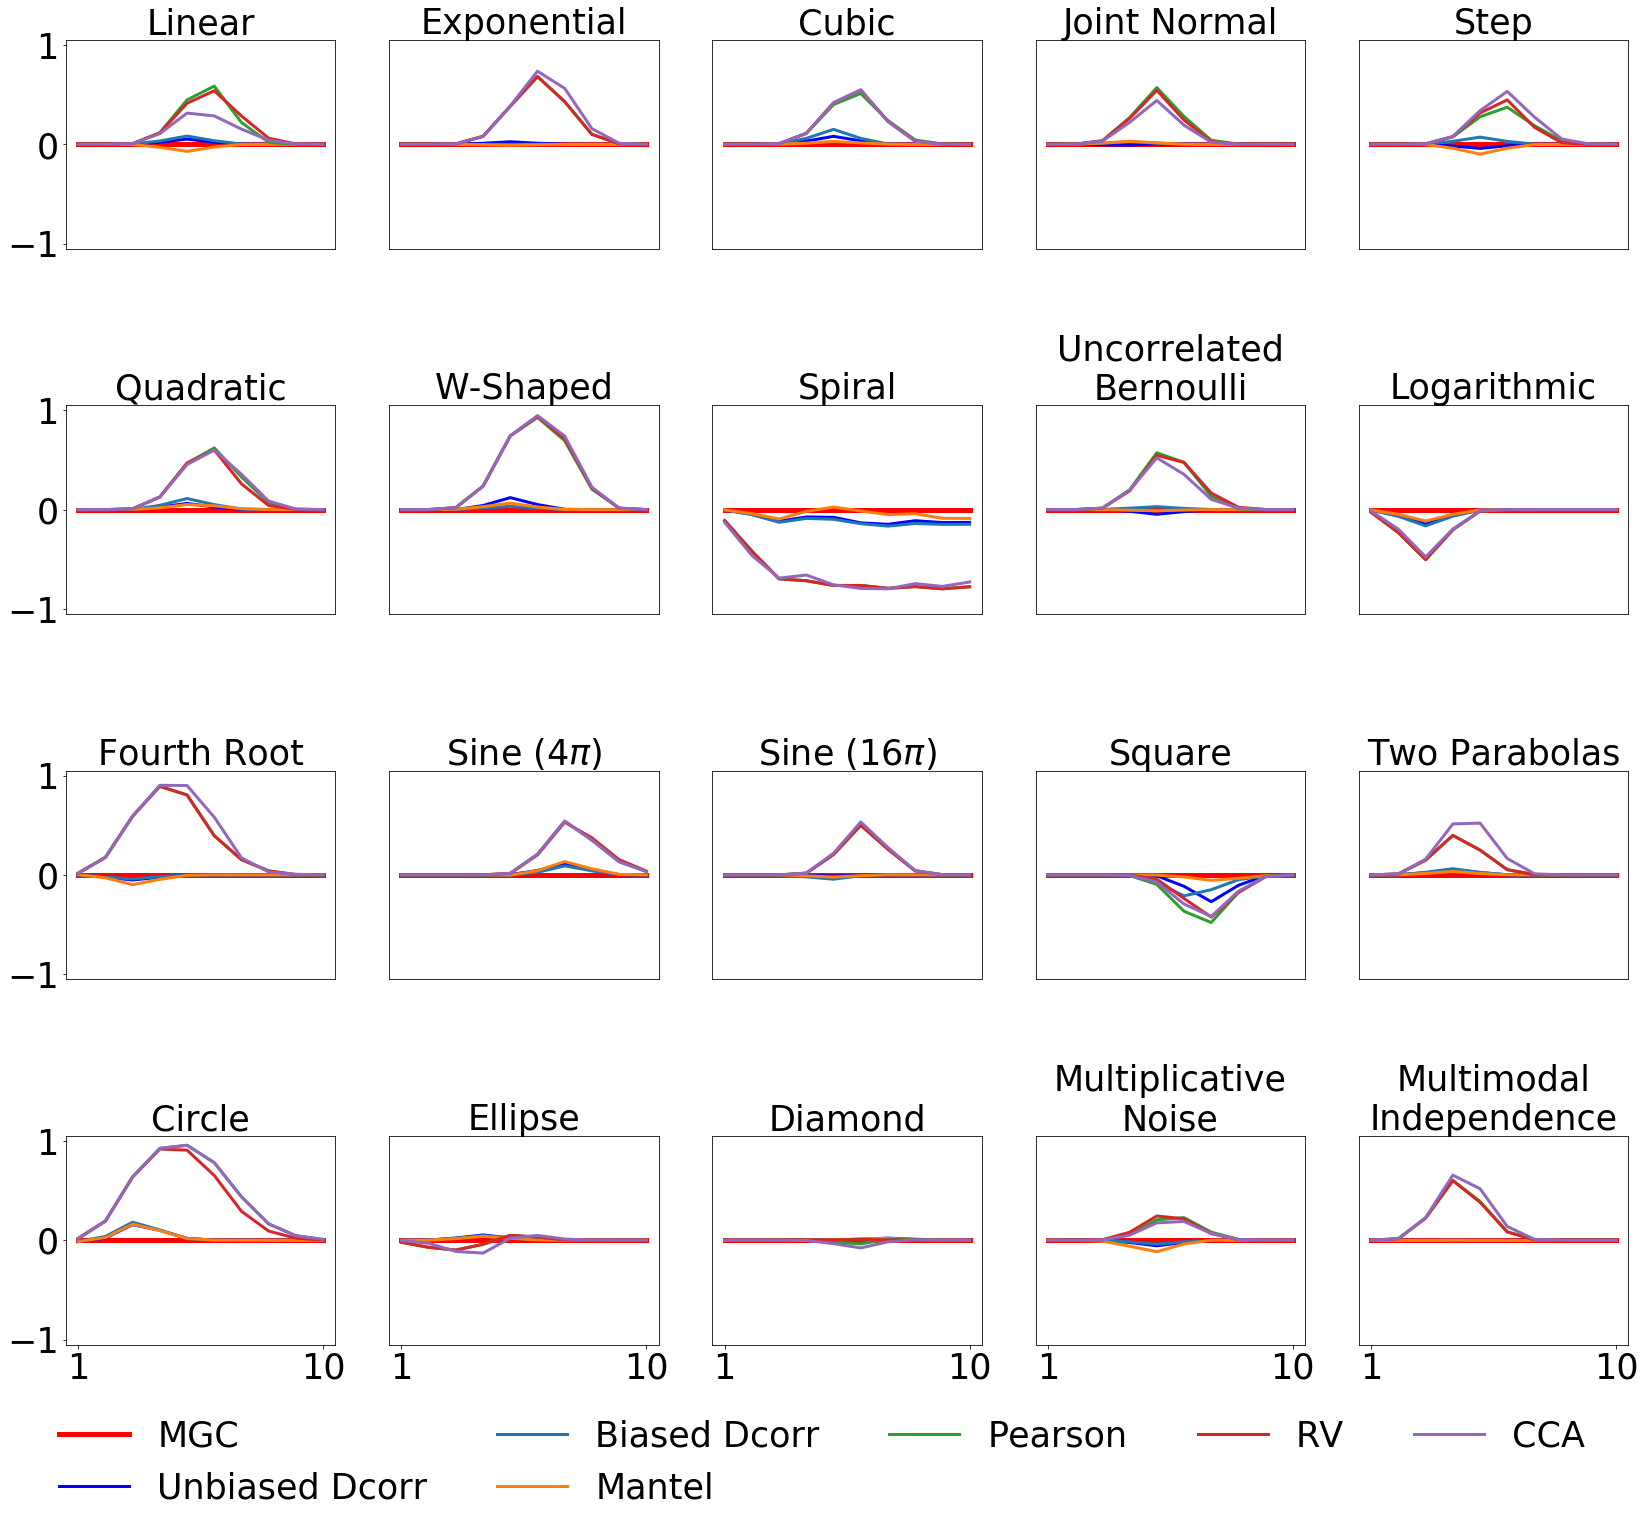

In [12]:
plot_all_curves()